In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root, fsolve
from adjustText import adjust_text
import periodictable
#!conda install periodictable --yes

The energy per nucleon is calculated by the equation:

$\epsilon_n(x,y) = m_py + m_n(1-y) -\alpha_n + \frac{\alpha_s}{x} + \alpha_cx^2y^2 + \alpha_{\alpha}(1-2y)^2$, where $x \equiv A^{1/3}$ and $y \equiv Z/A$

The next step is to calculate the x and y in order to minimize the energy / nucleon. The derivatives of the energy and their analytic solutions are:

\(
\begin{cases}
\left( \dfrac{\partial \epsilon_n}{\partial x} \right)_y = -\dfrac{\alpha_s}{x^2} + 2\alpha_c x y^2 = 0 \\
\left( \dfrac{\partial \epsilon_n}{\partial y} \right)_x = -\Delta m + 2\alpha_c x^2 y - 4\alpha_a (1 - 2y) = 0
\end{cases}

\begin{cases}
A = x^3 = \left( \dfrac{\alpha_s}{2\alpha_c} \right) \dfrac{1}{y^2} \\
\\
y = \dfrac{1 + \left( \dfrac{\Delta m}{4\alpha_a} \right)}{2 + \left( \dfrac{\alpha_c}{2\alpha_a} \right) x^2}
\end{cases}
\)



In [2]:
# 4 empirical constants
a_v = 15.71511
a_s = 17.53638
a_c = 0.71363
a_a = 23.37837
d_m = 939.565 - 938.272 # m_n - m_p

# Constants
hbarc = 197.327 # MeV fm
mc2 = 939 # MeV

In [3]:
def y(x):
    return np.sqrt(a_s/(2*a_c*x**3))
def f(x):
    return (1+(d_m/(4*a_a)))/(2+a_c*x**2/(2*a_a)) - y(x)


In [4]:
solution = root(f,5)
x = solution.x[0]
y_val = y(x)
A = x**3
Z = y_val*A
element = periodictable.elements[int(Z)]

print(f" Z = {Z}\n A = {A}\n x = {x}\n y = {y_val}")
print(f"Element: {element.name} ({element.symbol})")

 Z = 27.060587770161927
 A = 59.59881129073461
 x = 3.9061225614256485
 y = 0.45404576339878844
Element: cobalt (Co)


The element that appeared the most stable was the $_{27}Co$ which is close to the actual most stable element ($_{26}Fe$). Then we use the changed formula of binding energy:

$\epsilon_n(x,y,p_F)=m_py+m_n(1-y)-\alpha_n+\frac{\alpha_s}{x}+\alpha_cx^2y^2+\alpha_{\alpha}(1-2y)^2+\frac{3}{4}y^{4/3}p_F-C_lx^2y^2p_F$

The derivatives are equal to zero so:

\[
\begin{cases}
\left( \dfrac{\partial \epsilon_n}{\partial x} \right)_{y, p_F} = -\dfrac{\alpha_s}{x^2} + 2(\alpha_c - C_\ell p_F)x y^2 = 0 \\
\\
\left( \dfrac{\partial \epsilon_n}{\partial y} \right)_{x, p_F} = -\Delta m + 2(\alpha_c - C_\ell p_F)x^2 y - 4\alpha_a(1 - 2y) + y^{1/3} p_F = 0
\end{cases}
\]



In [5]:
def LDM(xy, p_f,Cl = 3.40665*10**(-3)):
    x, y = xy
    f1 = -a_s/x**2 + 2*(a_c-Cl*p_f)*x*y**2
    f2 = -d_m+2*(a_c-Cl*p_f)*x**2*y - 4*a_a*(1-2*y) + y**(1/3)*p_f
    return [f1,f2]

Cl_34 = []
Cl_0 = []

p_values = np.linspace(0, 40, 100)
for p_f in p_values:
    # Solve the LDM for Cl = 3.40665*10**(-3)
    x, y = fsolve(LDM, [1, 1], args=(p_f,))
    n = p_f**3/(3*np.pi**2)
    Cl_34.append({'p_f': p_f, 'x': x, 'y': y, 'n': n})

    # Solve the LDM for Cl = 0
    x, y = fsolve(LDM, [1, 1], args=(p_f, 0))
    Cl_0.append({'p_f': p_f, 'x': x, 'y': y, 'n': n})

dfCl_34 = pd.DataFrame(Cl_34)
dfCl_0 = pd.DataFrame(Cl_0)

In [6]:
print("Cl = 3.40665*10**(-3)")
print(dfCl_34.head())
print("\n Cl = 0")
print(dfCl_0.head())

Cl = 3.40665*10**(-3)
        p_f         x         y         n
0  0.000000  3.906123  0.454046  0.000000
1  0.404040  3.918367  0.452356  0.002228
2  0.808081  3.930667  0.450670  0.017821
3  1.212121  3.943023  0.448988  0.060147
4  1.616162  3.955436  0.447310  0.142572

 Cl = 0
        p_f         x         y         n
0  0.000000  3.906123  0.454046  0.000000
1  0.404040  3.916050  0.452320  0.002228
2  0.808081  3.926017  0.450599  0.017821
3  1.212121  3.936025  0.448881  0.060147
4  1.616162  3.946073  0.447168  0.142572


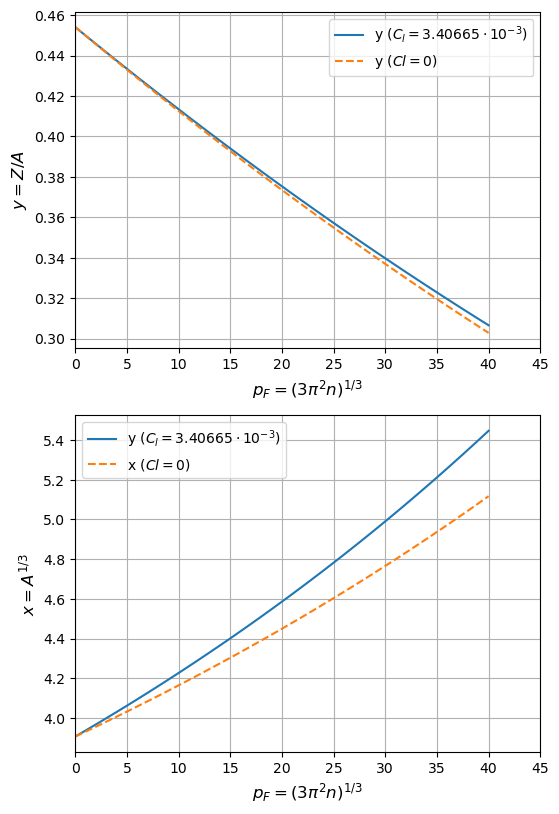

In [7]:
# Plotting the results
fig = plt.subplots(2, 1, figsize=(6, 10))
# Plot for Cl = 3.40665*10**(-3)
plt.subplot(2, 1, 1)
plt.plot(dfCl_34['p_f'], dfCl_34['y'], label=r'y ($C_l = 3.40665\cdot 10^{-3}$)')
plt.plot(dfCl_34['p_f'], dfCl_0['y'],linestyle='--', label=r'y ($Cl = 0$)')
plt.xlabel(r'$p_F=(3\pi^2n)^{1/3}$', fontsize=12)
plt.ylabel(r'$y=Z/A$', fontsize=12)
plt.xlim(min(dfCl_34['p_f']), max(dfCl_34['p_f']+5))
plt.legend()
plt.grid()
# Plot for Cl = 0
plt.subplot(2, 1, 2)
plt.plot(dfCl_34['p_f'], dfCl_34['x'], label=r'y ($C_l = 3.40665\cdot 10^{-3}$)')
plt.plot(dfCl_0['p_f'], dfCl_0['x'],linestyle='--', label=r'x ($Cl = 0$)')
plt.xlabel(r'$p_F=(3\pi^2n)^{1/3}$', fontsize=12)
plt.ylabel(r'$x=A^{1/3}$', fontsize=12)
plt.legend()
plt.grid()
plt.xlim(min(dfCl_34['p_f']), max(dfCl_34['p_f']+5))
#plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In order to see what happens in the structure of the crust we have to assume that $m_n \equiv m_p = m$ and the density becomes $\rho = n \cdot m$,
where n is the baryon density and m is the mass of a baryon. Then we can calculate the $1 g/cm^3$ in MeV

In [8]:
fm_to_m = 1e-15
kg_to_MeV = 5.60958885e29
rho_kg_per_m3 = 1e3

rho_MeV_per_fm3 = rho_kg_per_m3 * kg_to_MeV / 1e45
fm3_to_MeV3 = hbarc**3
rho__MeV4 = rho_MeV_per_fm3 * fm3_to_MeV3

print(f"1 g/cm^3 = {rho__MeV4} MeV^4")

1 g/cm^3 = 4.3101320014760604e-06 MeV^4


We calculated that: 

\begin{equation}
    1 g / cm^3 = 4.3101320\cdot10^{-6} MeV^4
\end{equation}


In [14]:
rho = np.logspace(6, 11.2, 1000) # from the crust paper
rho = rho*rho__MeV4
n = rho / mc2
pfermi = (3 * np.pi**2 * n)**(1/3)
pfermi

array([ 0.51414071,  0.51619888,  0.5182653 ,  0.52033998,  0.52242297,
        0.5245143 ,  0.526614  ,  0.52872211,  0.53083866,  0.53296367,
        0.5350972 ,  0.53723926,  0.5393899 ,  0.54154915,  0.54371705,
        0.54589362,  0.54807891,  0.55027294,  0.55247576,  0.55468739,
        0.55690788,  0.55913725,  0.56137556,  0.56362282,  0.56587907,
        0.56814436,  0.57041872,  0.57270218,  0.57499479,  0.57729657,
        0.57960756,  0.58192781,  0.58425735,  0.58659621,  0.58894443,
        0.59130205,  0.59366911,  0.59604565,  0.5984317 ,  0.6008273 ,
        0.6032325 ,  0.60564732,  0.6080718 ,  0.610506  ,  0.61294993,
        0.61540365,  0.6178672 ,  0.6203406 ,  0.62282391,  0.62531716,
        0.62782039,  0.63033363,  0.63285694,  0.63539036,  0.63793391,
        0.64048764,  0.6430516 ,  0.64562582,  0.64821035,  0.65080522,
        0.65341048,  0.65602617,  0.65865233,  0.66128901,  0.66393623,
        0.66659406,  0.66926252,  0.67194167,  0.67463154,  0.67

In [15]:
results = []
for pf in pfermi:
    x, y = fsolve(LDM, [1,1], args=(pf))
    A = int(x**3)
    Z = int(y*A)
    N = A - Z
    element = periodictable.elements[Z]
    results.append({'p_f': pf, 'A': A, 'Z': Z, 'N': N,'element_name': element.name, 'element': element.symbol})

df_results = pd.DataFrame(results)

In [16]:
df_results

,p_f,A,Z,N,element_name,element
0,0.514141,60,27,33,cobalt,Co
1,0.516199,60,27,33,cobalt,Co
2,0.518265,60,27,33,cobalt,Co
3,0.520340,60,27,33,cobalt,Co
4,0.522423,60,27,33,cobalt,Co
...,...,...,...,...,...,...
995,27.382623,116,40,76,zirconium,Zr
996,27.492240,116,40,76,zirconium,Zr
997,27.602295,116,40,76,zirconium,Zr
998,27.712790,117,40,77,zirconium,Zr


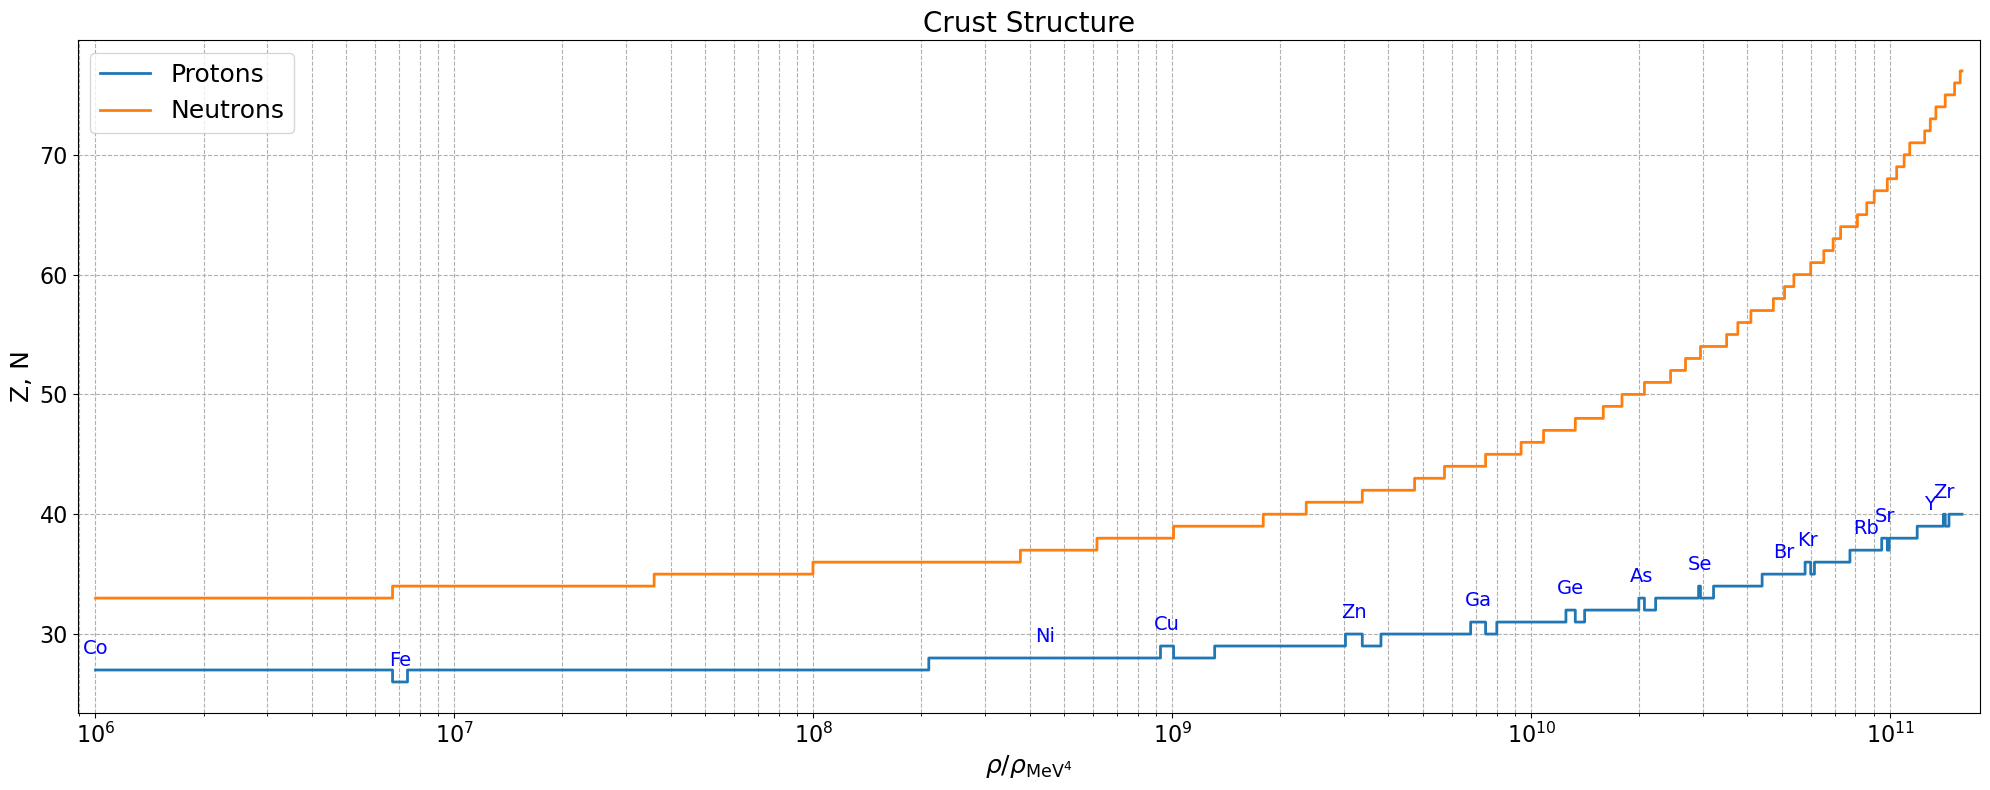

In [52]:
df_results['rho_norm'] = df_results['p_f']**3 / (3 * np.pi**2) * mc2 / rho__MeV4

step_indices = [0] + list(df_results['Z'].diff().abs().round(6).ne(0).to_numpy().nonzero()[0])
step_indices.append(len(df_results) - 1)

rho_steps = df_results['rho_norm'].iloc[step_indices].values
Z_steps = df_results['Z'].iloc[step_indices].values
symbols = df_results['element'].iloc[step_indices].values

plt.figure(figsize=(20, 8))
plt.step(df_results['rho_norm'], df_results['Z'], where='post', label='Protons', linewidth=2)
plt.step(df_results['rho_norm'], df_results['N'], where='post', label='Neutrons', linewidth=2)

# Annotate only when Z changes
used_symbols = set()
for i in range(len(rho_steps)-1):
    symbol = symbols[i]
    if symbol not in used_symbols:
        # Use geometric mean for log scale
        x_center = np.sqrt(rho_steps[i] * rho_steps[i+1])
        plt.text(x_center, Z_steps[i]+1, symbol, ha='center', va='bottom', fontsize=14, color='blue')
        used_symbols.add(symbol)


plt.xlabel(r'$\rho / \rho_{\mathrm{MeV}^4}$', fontsize=18)
plt.ylabel(r'Z, N', fontsize=18)
plt.xscale('log')
plt.xlim(10**(5.95),10**(11.25))
plt.legend(fontsize=18)
plt.grid(True, which='both', ls='--')
plt.title(r'Crust Structure', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)  # Make ticks bigger
plt.tight_layout()
plt.show()